使用设备: cuda


c:\Users\Windows11\anaconda3\envs\stylegan\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows11\anaconda3\envs\stylegan\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


原始图像尺寸: torch.Size([512, 512])
开始DeepDream处理...
处理八度 1/3
  迭代 0/50, 损失: -2185.6726
  迭代 20/50, 损失: -7930.4624
  迭代 40/50, 损失: -12455.3213
处理八度 2/3
  上采样: torch.Size([261, 261]) -> torch.Size([365, 365])
  迭代 0/50, 损失: -7340.6270
  迭代 20/50, 损失: -16385.6836
  迭代 40/50, 损失: -22385.0352
处理八度 3/3
  上采样: torch.Size([365, 365]) -> torch.Size([512, 512])
  迭代 0/50, 损失: -12868.8926
  迭代 20/50, 损失: -26009.0039
  迭代 40/50, 损失: -34606.3555


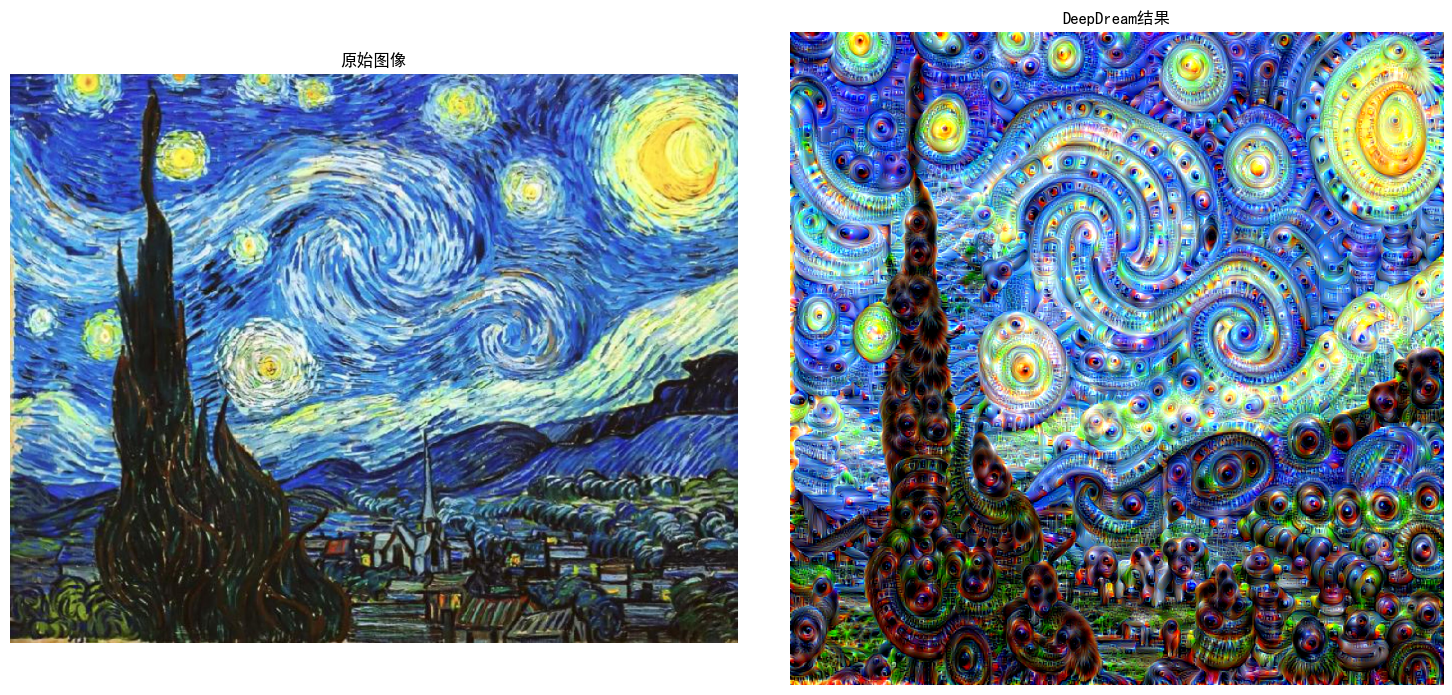

DeepDream结果已保存为 'deepdream_output.jpg'


In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

class DeepDream:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"使用设备: {device}")
        
        # 加载预训练的VGG16模型
        self.model = models.vgg16(pretrained=True).features
        self.model.to(self.device)
        self.model.eval()
        
        # 冻结模型参数
        for param in self.model.parameters():
            param.requires_grad = False
            
    def preprocess_image(self, image_path, img_size=512):
        """预处理输入图像"""
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0)
        return image_tensor.to(self.device)
    
    def deprocess_image(self, tensor):
        """将张量转换回图像格式"""
        tensor = tensor.squeeze(0).cpu().detach()
        
        # 反标准化
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        
        # 裁剪到[0,1]范围
        tensor = torch.clamp(tensor, 0, 1)
        
        # 转换为numpy数组
        image = tensor.numpy()
        image = np.transpose(image, (1, 2, 0))
        return image
    
    def get_layer_output(self, x, layer_idx):
        """获取指定层的输出"""
        layers = list(self.model.children())
        for i, layer in enumerate(layers):
            x = layer(x)
            if i == layer_idx:
                return x
        return x
    
    def dream(self, image_path, layer_idx=20, num_iters=100, lr=0.01, 
              octave_scale=1.4, num_octaves=4, strength=0.01):
        """
        DeepDream主函数
        """
        
        # 预处理原始图像
        original_img = self.preprocess_image(image_path)
        original_size = original_img.shape[2:]
        
        print(f"原始图像尺寸: {original_size}")
        
        # 创建多尺度图像金字塔
        octaves = [original_img]
        for i in range(num_octaves - 1):
            new_size = (int(original_size[0] / (octave_scale ** (i + 1))),
                       int(original_size[1] / (octave_scale ** (i + 1))))
            resized = nn.functional.interpolate(original_img, size=new_size, 
                                              mode='bilinear', align_corners=False)
            octaves.append(resized)
        
        # 从最小尺度开始处理
        dream_img = octaves[-1].clone().requires_grad_(True)
        
        print("开始DeepDream处理...")
        for octave in range(num_octaves):
            print(f"处理八度 {octave + 1}/{num_octaves}")
            
            if octave > 0:
                # 上采样到下一个尺度，并重新设置requires_grad
                current_size = dream_img.shape[2:]
                target_size = octaves[num_octaves - octave - 1].shape[2:]
                print(f"  上采样: {current_size} -> {target_size}")
                
                # 分离计算图并重新创建可训练变量
                with torch.no_grad():
                    dream_img_nograd = nn.functional.interpolate(
                        dream_img, size=target_size, mode='bilinear', align_corners=False
                    )
                dream_img = dream_img_nograd.clone().requires_grad_(True)
            
            # 为当前八度创建优化器
            optimizer = optim.Adam([dream_img], lr=lr)
            
            for iteration in range(num_iters):
                optimizer.zero_grad()
                
                # 获取目标层的激活
                activations = self.get_layer_output(dream_img, layer_idx)
                
                # 损失函数：最大化激活的L2范数
                loss = -activations.norm()
                loss.backward()
                
                # 添加一些随机性来创造更有趣的图案
                if strength > 0:
                    dream_img.grad.data += strength * torch.randn_like(dream_img.grad.data)
                
                optimizer.step()
                
                if iteration % 20 == 0:
                    print(f"  迭代 {iteration}/{num_iters}, 损失: {loss.item():.4f}")
        
        # 获取最终结果
        final_result = self.deprocess_image(dream_img)
        return final_result

def visualize_comparison(original_path, dream_image, save_path=None):
    """可视化原始图像和DeepDream结果的对比"""
    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # 显示原始图像
    original_img = Image.open(original_path)
    ax1.imshow(original_img)
    ax1.set_title('原始图像')
    ax1.axis('off')
    
    # 显示DeepDream结果
    ax2.imshow(dream_image)
    ax2.set_title('DeepDream结果')
    ax2.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# 使用示例
if __name__ == "__main__":
    # 初始化DeepDream
    dreamer = DeepDream()
    
    # 运行DeepDream
    image_path = "deepdream_input.jpg"  # 替换为你的图像路径
    
    try:
        # 生成DeepDream图像
        dream_image = dreamer.dream(
            image_path=image_path,
            layer_idx=20,      # 通常选择较深的层（5-25之间）
            num_iters=50,      # 迭代次数
            lr=0.02,           # 学习率
            num_octaves=3,     # 八度数量
            strength=0.01      # 增强强度
        )
        
        # 显示结果对比
        visualize_comparison(image_path, dream_image, "deepdream_result.jpg")
        
        # 单独保存DeepDream结果
        plt.imsave("deepdream_output.jpg", dream_image)
        print("DeepDream结果已保存为 'deepdream_output.jpg'")
        
    except FileNotFoundError:
        print(f"找不到图像文件: {image_path}")
        print("创建测试图像...")
        
        # 创建测试图像
        test_image = np.random.rand(512, 512, 3) * 255
        test_image = test_image.astype(np.uint8)
        Image.fromarray(test_image).save("test_image.jpg")
        print("测试图像已创建为 'test_image.jpg'")

使用设备: cuda


c:\Users\Windows11\anaconda3\envs\stylegan\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows11\anaconda3\envs\stylegan\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


原始图像尺寸: torch.Size([512, 512])
开始DeepDream处理...
处理八度 1/1
  迭代 0/30, 损失: -3584.5220
  迭代 20/30, 损失: -10202.7041
原始图像尺寸: torch.Size([512, 512])
开始DeepDream处理...
处理八度 1/2
  迭代 0/30, 损失: -2695.3403
  迭代 20/30, 损失: -7469.4443
处理八度 2/2
  上采样: torch.Size([365, 365]) -> torch.Size([512, 512])
  迭代 0/30, 损失: -6256.6328
  迭代 20/30, 损失: -13820.4736
原始图像尺寸: torch.Size([512, 512])
开始DeepDream处理...
处理八度 1/3
  迭代 0/30, 损失: -2185.6726
  迭代 20/30, 损失: -5611.3159
处理八度 2/3
  上采样: torch.Size([261, 261]) -> torch.Size([365, 365])
  迭代 0/30, 损失: -4531.5151
  迭代 20/30, 损失: -9939.6494
处理八度 3/3
  上采样: torch.Size([365, 365]) -> torch.Size([512, 512])
  迭代 0/30, 损失: -7601.0498
  迭代 20/30, 损失: -15424.2373
原始图像尺寸: torch.Size([512, 512])
开始DeepDream处理...
处理八度 1/4
  迭代 0/30, 损失: -1763.9810
  迭代 20/30, 损失: -4216.6826
处理八度 2/4
  上采样: torch.Size([186, 186]) -> torch.Size([261, 261])
  迭代 0/30, 损失: -3304.6521
  迭代 20/30, 损失: -7305.2480
处理八度 3/4
  上采样: torch.Size([261, 261]) -> torch.Size([365, 365])
  迭代 0/30, 损失: -5500

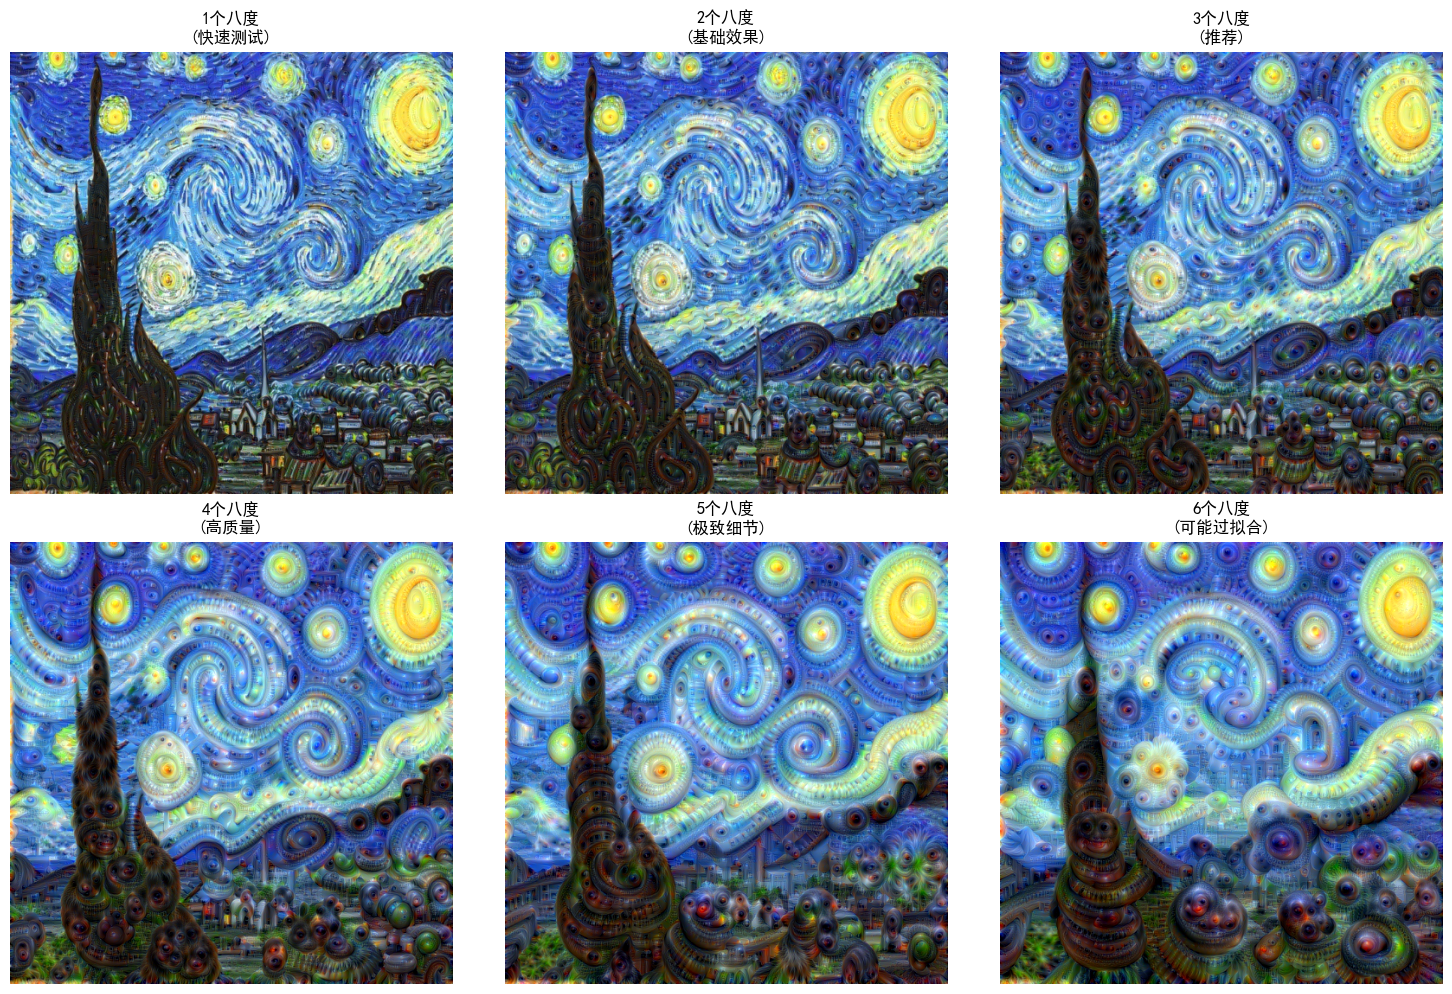

In [2]:
import matplotlib.pyplot as plt

def compare_octaves(image_path):
    """比较不同八度数量的效果"""
    dreamer = DeepDream()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    octave_configs = [
        (1, "1个八度\n(快速测试)"),
        (2, "2个八度\n(基础效果)"), 
        (3, "3个八度\n(推荐)"),
        (4, "4个八度\n(高质量)"),
        (5, "5个八度\n(极致细节)"),
        (6, "6个八度\n(可能过拟合)")
    ]
    
    for i, (num_octaves, title) in enumerate(octave_configs):
        row, col = i // 3, i % 3
        
        try:
            # 生成梦境图像
            dream_img = dreamer.dream(
                image_path=image_path,
                num_octaves=num_octaves,
                num_iters=30,  # 减少迭代以加快演示
                lr=0.01
            )
            
            axes[row, col].imshow(dream_img)
            axes[row, col].set_title(title)
            axes[row, col].axis('off')
            
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f"错误\n{str(e)}", 
                              ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].set_title(title)
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# 运行比较
compare_octaves("deepdream_input.jpg")